In [ ]:
'''
#In this file, 
Go through the df_iemocap_recognition.csv file, for every row, use roberta ,hubert and librosa to extract features, store in .pkl file.:
Use sliding windows, create sequence data, contain current sentence and history (past two sentence)
in order to deal with history, use the index column.
    if current index >=3, then HISTORY_LENGTH = 2, use past two sentences .
    if current index <3, then history num = (index-1), 
    index=1, means current sentence is the first sentence, HISTORY_LENGTH=0, 
    index =2, means current sentence is the second sentence, HISTORY_LENGTH=1



'''
# --- Imoort libraries ---
import os
import soundfile as sf
import pandas as pd
import torch
from transformers import RobertaTokenizer, HubertModel, HubertConfig
import numpy as np
from tqdm import tqdm
import pickle
import librosa     # for extract mfcc etc feature

c:\Users\liyua\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# --- Configuration ---
IEMOCAP_DIR = "../../dataset/IEMOCAP_full_release"  
SESSIONS = ["Session1", "Session2", "Session3", "Session4", "Session5"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#OUTPUT_CSV_DIR = "data/preprocess/"
OUTPUT_PKL_DIR = "../../data"
OUTPUT_PKL_FILENAME = "iemocap_preprocessed_data.pkl"
TRANSCRIPT_CSV = "../../data/df_iemocap.csv"  
HISTORY_LENGTH = 3  # Number of previous utterances to consider

In [3]:
# --- Models and Tokenizers ---
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
hubert_config = HubertConfig.from_pretrained("facebook/hubert-base-ls960")
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(DEVICE)
hubert_model.eval()

HubertModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): HubertEncoder(
    (pos_conv_embed): HubertPositionalConvEmbedding(
      (conv): Para

In [ ]:
# use Hubert to extract audio feature
def extract_audio_features(audio_path):
    """Extract HuBERT features from audio."""
    audio, sr = sf.read(audio_path)
    audio_tensor = torch.tensor(audio).unsqueeze(0).to(DEVICE).float()
    with torch.no_grad():
        outputs = hubert_model(audio_tensor)
    return outputs.last_hidden_state.squeeze(0).cpu().numpy()

#  get transcript for audio file
def get_transcription(audio_file_path, df_iemocap):
    """Get transcription from the provided CSV DataFrame."""
    audio_filename = os.path.basename(audio_file_path)
    print (audio_filename)
    if audio_filename in df_iemocap['wav_file'].values:
        return df_iemocap.loc[df_iemocap['wav_file'] == audio_filename, 'script'].iloc[0]
    else:
        print(f"Warning: Transcription not found for {audio_filename}")
        return "Transcription not found."  # Or handle missing transcript as needed



In [14]:
# ---Extract MFCC Feature----
def extract_mfcc_features(audio_path, n_mfcc=40):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
        mfccs = np.concatenate((mfccs, mfccs_delta, mfccs_delta2), axis=0)
        mfccs = np.transpose(mfccs)
        return mfccs
    except Exception as e:
        print(f"Error extracting MFCC features: {e}")
        return None

# ---Extract Spectrogram----
def extract_mel_spectrogram(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max) #convert to decibels.
        mel_spectrogram = np.transpose(mel_spectrogram)
        return mel_spectrogram
    except Exception as e:
        print(f"Error extracting Mel Spectrogram: {e}")
        return None

# ---Extract RMS ----
def extract_rms(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        rms = librosa.feature.rms(y=y)
        rms = np.transpose(rms)
        return rms
    except Exception as e:
        print(f"Error extracting RMS: {e}")
        return None

In [15]:
# test MFCC,Spectrogram,RMS on single file
import librosa
from IPython.display import Audio
import os

audio_path = '../../dataset/IEMOCAP_full_release/Session1/Sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav'

# Load an audio file as a floating point time series. 
# Audio will be automatically resampled to the given rate (default sr=22050 )
y, sr = librosa.load(audio_path, sr=44100)
y, sr

Audio(y, rate=44100)
    
if os.path.exists(audio_path):  
    print("audio_path:",audio_path)       
    mfcc_features = extract_mfcc_features(audio_path)
    mel_spectrogram = extract_mel_spectrogram(audio_path)
    rms = extract_rms(audio_path)
    print("mfcc_features",mfcc_features)
    print("mel_spectrogram",mel_spectrogram)
    print("rms",rms)



audio_path: ../../dataset/IEMOCAP_full_release/Session1/Sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
mfcc_features [[-4.24004242e+02  1.02635391e+02 -8.76728344e+00 ... -1.44841194e-01
   3.34935337e-01  2.11471450e-02]
 [-3.99918243e+02  1.15399734e+02 -1.41583595e+01 ... -1.44841194e-01
   3.34935337e-01  2.11471450e-02]
 [-4.13643829e+02  1.24355049e+02 -1.62880039e+01 ... -1.44841194e-01
   3.34935337e-01  2.11471450e-02]
 ...
 [-4.35665436e+02  1.09929962e+02 -9.52774143e+00 ...  2.12691873e-01
  -1.28426120e-01 -1.50519654e-01]
 [-4.45630249e+02  1.13398872e+02 -5.56852531e+00 ...  2.12691873e-01
  -1.28426120e-01 -1.50519654e-01]
 [-4.57864838e+02  1.15038353e+02 -1.02060711e+00 ...  2.12691873e-01
  -1.28426120e-01 -1.50519654e-01]]
mel_spectrogram [[-36.842896 -31.694485 -34.28975  ... -75.7636   -75.82804  -75.76541 ]
 [-31.827213 -29.304138 -28.40535  ... -80.       -80.       -80.      ]
 [-28.698444 -26.491756 -29.35964  ... -80.       -80.       -80.      ]
 ...
 

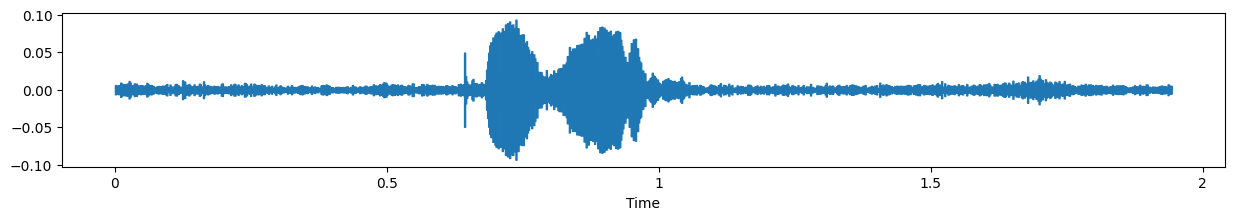

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,2))
librosa.display.waveshow(y,sr=sr, max_points=1000)

In [17]:
def load_preprocessed_data(pkl_dir):
    """Load preprocessed data from .pkl file."""
    pkl_path = os.path.join(pkl_dir, OUTPUT_PKL_FILENAME )
    if os.path.exists(pkl_path):
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
        return data
    else:
        return []

In [31]:
def create_sequence_pairs(data):
    sequence_data = []
    print("Create sequence data...")   
    for i in range(len(data) ):
        current_data = data[i]   
        print(current_data["index"])
        history = []

        # first sentence no history, second sentence only has one history, third or later sentence has 2 history
        if current_data["index"]<3:
            history_length = current_data["index"]-1
        else:
            history_length = HISTORY_LENGTH      

        for j in range(max(0, i - history_length), i):
            history.append({
                "input_ids": data[j]["input_ids"],
                "attention_mask": data[j]["attention_mask"],
                "hubert_features": data[j]["hubert_features"],
                "mfcc_features": data[j]["mfcc_features"],
                "mel_spectrogram": data[j]["mel_spectrogram"],
                "rms": data[j]["rms"],                
                "label": data[j]["label"]
            })

        sequence_data.append({
            "history": history,
            "current_hubert": current_data["hubert_features"],
            "current_mfcc": current_data["mfcc_features"],
            "current_mel": current_data["mel_spectrogram"],
            "current_rms": current_data["rms"],
            "current_text": current_data["transcription"],
            "next_label": current_data["next_label"],
        })

    return sequence_data

 

In [ ]:
# test on one file
def test_preprocess_iemocap(df_iemocap, output_dir):
    """Preprocess data using audio filenames from the transcript CSV."""
    os.makedirs(output_dir, exist_ok=True)
    data = []
    
    row = df_iemocap.iloc[0]
    audio_filename = row['wav_file']
    audio_subpath = audio_filename[:audio_filename.rfind("_")]
    audio_path = IEMOCAP_DIR +"/Session" + audio_filename[4]+ "/sentences/wav/"+ audio_subpath + "/"+ audio_filename+".wav"
    #audio_path = os.path.join(IEMOCAP_DIR, "Session" + audio_filename[3], "sentences", "wav", audio_filename)  # Reconstruct audio path.
        
    if os.path.exists(audio_path):       
       

        print("audio_path:",audio_path)
        transcription = get_transcription(audio_filename, df_iemocap)
        hubert_features  = extract_audio_features(audio_path)
        mfcc_features = extract_mfcc_features(audio_path)
        mel_spectrogram = extract_mel_spectrogram(audio_path)
        rms = extract_rms(audio_path)

        text_tokens = roberta_tokenizer(transcription, padding=True, truncation=True, return_tensors="pt")
        text_tokens = {key: value.squeeze(0).cpu().numpy() for key, value in text_tokens.items()}       
        label = row['label'] 
        index = row['index']
        next_label = row['next_label'] 
        print("label",label)

        data.append({
            "audio_file": audio_filename,
            "hubert_features": hubert_features,
            "mfcc_features": mfcc_features,
            "mel_spectrogram": mel_spectrogram,
            "rms": rms,
            "input_ids": text_tokens["input_ids"],
            "attention_mask": text_tokens["attention_mask"],
            "transcription": transcription,
            "audio_path": audio_path,
            "label": label,    
            "next_label": next_label,   
            "index": index       
        })            
        
        
    
    sequence_data = create_sequence_pairs(data)
    
    pkl_path = os.path.join(output_dir, "iemocap_preprocessed_data.pkl")
    with open(pkl_path, 'wb') as f:
        pickle.dump(sequence_data, f)
    print(f"Data preprocessed and saved to {pkl_path}")
    return


df_iemocap = pd.read_csv(TRANSCRIPT_CSV)  # Load the transcript CSV
#df_iemocap.tail()
test_preprocess_iemocap(df_iemocap, OUTPUT_PKL_DIR)
loaded_data = load_preprocessed_data(OUTPUT_PKL_DIR)

if loaded_data:
    example_data = loaded_data[0]
    print("Example Loaded Data:")
    print(f"History Length: {len(example_data['history'])}")
    print(f"Current Hubert Shape: {example_data['current_hubert'].shape}")
    print(f"Current MFCC Shape: {example_data['current_mfcc'].shape}")
    print(f"Current Mel Shape: {example_data['current_mel'].shape}")
    print(f"Current RMS Shape: {example_data['current_rms'].shape}")
    print(f"Current Text Shape: {example_data['current_text']}")
    print(f"Next Label: {example_data['next_label']}")



else:
    print("No preprocessed data loaded.")


audio_path: ../../dataset/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
Ses01F_impro01_F000
label neu
Create sequence data...
1
Data preprocessed and saved to ../../data\iemocap_preprocessed_data.pkl
Example Loaded Data:
History Length: 0
Current Hubert Shape: (97, 768)
Current MFCC Shape: (61, 120)
Current Mel Shape: (61, 128)
Current RMS Shape: (61, 1)
Current Text Shape: Excuse me.
Next Label: fru


In [ ]:
# preprocess all file
def preprocess_iemocap(df_iemocap, output_dir):
    """Preprocess data using audio filenames from the transcript CSV."""
    os.makedirs(output_dir, exist_ok=True)
    data = []  
  
    for _, row in tqdm(df_iemocap.iterrows()):
        # get audio filename and audio file full path
        audio_filename = row['wav_file']
        audio_subpath = audio_filename[:audio_filename.rfind("_")]
        audio_path = IEMOCAP_DIR +"/Session" + audio_filename[4]+ "/sentences/wav/"+ audio_subpath + "/"+ audio_filename+".wav"
        #audio_path = os.path.join(IEMOCAP_DIR, "Session" + audio_filename[3], "sentences", "wav", audio_filename)  # Reconstruct audio path.
  
        if os.path.exists(audio_path):

            print("audio_path:",audio_path)
            transcription = get_transcription(audio_filename, df_iemocap)
            hubert_features  = extract_audio_features(audio_path)
            mfcc_features = extract_mfcc_features(audio_path)
            mel_spectrogram = extract_mel_spectrogram(audio_path)
            rms = extract_rms(audio_path)

            text_tokens = roberta_tokenizer(transcription, padding=True, truncation=True, return_tensors="pt")
            text_tokens = {key: value.squeeze(0).cpu().numpy() for key, value in text_tokens.items()}            
            label = row['label'] 
            index = row['index']
            next_label = row['next_label'] 
            #print("label",label)

            data.append({
                "audio_file": audio_filename,
                "hubert_features": hubert_features,
                "mfcc_features": mfcc_features,
                "mel_spectrogram": mel_spectrogram,
                "rms": rms,
                "input_ids": text_tokens["input_ids"],
                "attention_mask": text_tokens["attention_mask"],
                "transcription": transcription,
                "audio_path": audio_path,
                "label": label,
                "next_label": next_label,   
                "index": index       
            })            
        else:
            print(f"Warning: Audio file not found at {audio_path}")

    sequence_data = create_sequence_pairs(data)

    pkl_path = os.path.join(output_dir, "preprocessed_data.pkl")
    with open(pkl_path, 'wb') as f:
        pickle.dump(sequence_data, f)
    print(f"Data preprocessed and saved to {pkl_path}")

In [ ]:
df_iemocap = pd.read_csv(TRANSCRIPT_CSV)
preprocess_iemocap(df_iemocap, OUTPUT_PKL_DIR)
loaded_data = load_preprocessed_data(OUTPUT_PKL_DIR)

if loaded_data:
    example_data = loaded_data[0]
    print("Example Loaded Data:")
    print(f"History Length: {len(example_data['history'])}")
    print(f"Current Hubert Shape: {example_data['current_hubert'].shape}")
    print(f"Current MFCC Shape: {example_data['current_mfcc'].shape}")
    print(f"Current Mel Shape: {example_data['current_mel'].shape}")
    print(f"Current RMS Shape: {example_data['current_rms'].shape}")
    print(f"Current Text Shape: {example_data['current_text'].shape}")
    print(f"Next Label: {example_data['next_label']}")
else:
    print("No preprocessed data loaded.")

0it [00:00, ?it/s]

audio_path: dataset/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
Ses01F_impro01_F000


1it [00:00,  3.16it/s]

label neu
audio_path: dataset/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M000.wav
Ses01F_impro01_M000


2it [00:00,  2.74it/s]

label fru


Data preprocessed and saved to data/preprocess/preprocessed_data.csv
Example Loaded Data:
Audio Features Shape: (74496,)
Input IDs Shape: (6,)
Transcription: Excuse me.
Audio Path: dataset/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
